<ipython-input-4-7836e367f9b9>:16: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-4-7836e367f9b9>:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
<ipython-input-4-7836e367f9b9>:16: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


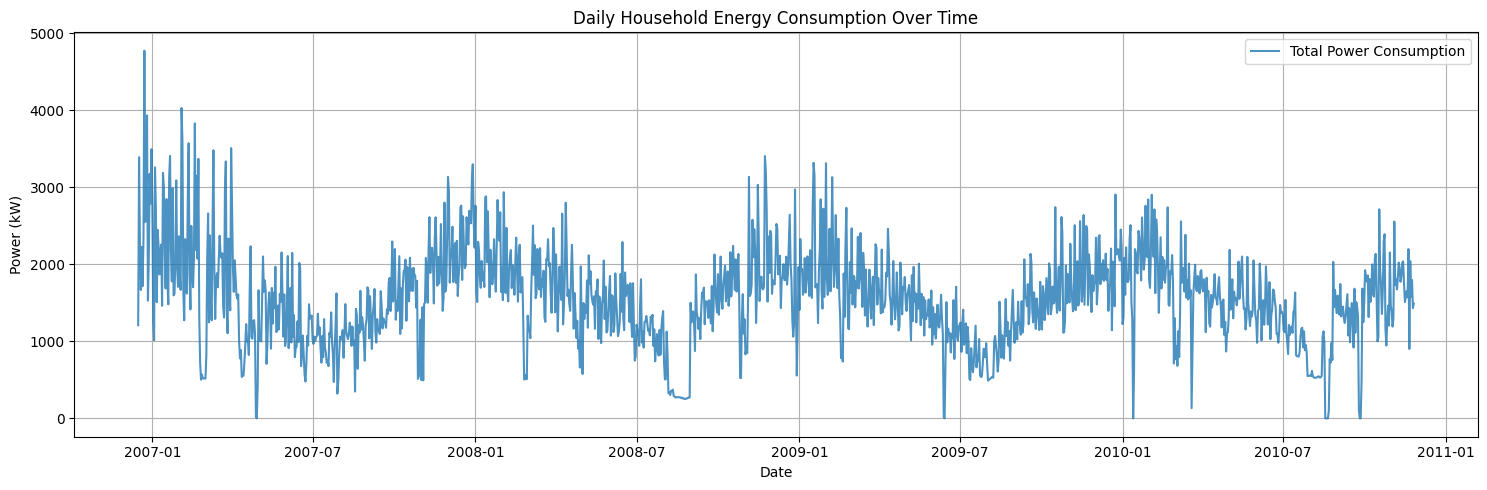

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings


# Load energy consumption dataset
df = pd.read_csv(
    "/content/household_power_consumption.txt",
    sep=';',
    parse_dates=[[0, 1]],
    infer_datetime_format=True,
    na_values='?',
    low_memory=False
)

# Data cleaning - remove missing values
df.dropna(inplace=True)

# Feature engineering - calculate unmetered energy usage
df['Other_energy'] = (
    df['Global_active_power'] * 1000 / 60
    - df['Sub_metering_1']
    - df['Sub_metering_2']
    - df['Sub_metering_3']
)

# Convert to datetime and set as index
df['Date_Time'] = pd.to_datetime(df['Date_Time'])
df.set_index('Date_Time', inplace=True)

# Resample to daily frequency
daily_df = df.resample('d').sum()


# Visualization of daily energy consumption
plt.figure(figsize=(15, 5))

plt.plot(daily_df.index, daily_df['Global_active_power'], label='Total Power Consumption', alpha=0.8)
plt.title('Daily Household Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
# Stationarity Analysis
def adf_test(series, title):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    print(f"\nAugmented Dickey-Fuller Test Results for: {title}")
    result = adfuller(series.dropna())

    # Print test statistics
    print(f'ADF Test Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for significance_level, value in result[4].items():
        print(f'\t{significance_level}%: {value:.4f}')

    # Interpret results
    if result[1] < 0.05:
        print("Conclusion: Series is stationary (reject null hypothesis)")
    else:
        print("Conclusion: Series is non-stationary (fail to reject null hypothesis)")


# Time Series Decomposition
def decompose_time_series(series, seasonal_period, model='additive'):
    """Decompose time series into trend, seasonal, and residual components"""
    decomposition = seasonal_decompose(series, model=model, period=seasonal_period)

    # Create visualization
    plt.figure(figsize=(12, 8))

    # Original Series
    plt.subplot(411)
    plt.plot(series, label='Observed Values')
    plt.legend(loc='upper left')
    plt.title('Original Time Series')

    # Trend Component
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='red')
    plt.legend(loc='upper left')
    plt.title('Long-Term Trend Pattern')

    # Seasonal Component
    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonality', color='blue')
    plt.legend(loc='upper left')
    plt.title('Seasonal Variations')

    # Residual Component
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='black')
    plt.legend(loc='upper left')
    plt.title('Remaining Noise (Residuals)')

    plt.tight_layout()
    plt.show()

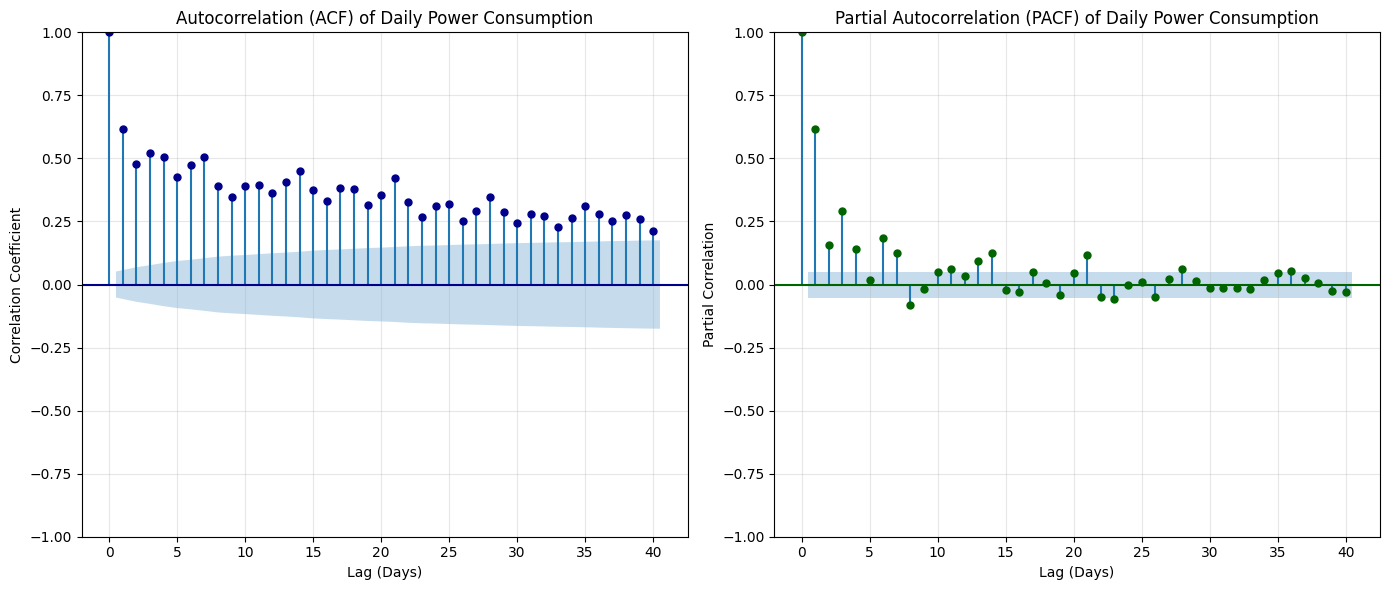


            Time Series Stationarity Evaluation             

Augmented Dickey-Fuller Test Results for: Daily Power Consumption Data
ADF Test Statistic: -3.8498
p-value: 0.0024
Critical Values:
	1%%: -3.4350
	5%%: -2.8636
	10%%: -2.5679
Conclusion: Series is stationary (reject null hypothesis)

              Time Series Components Analysis               


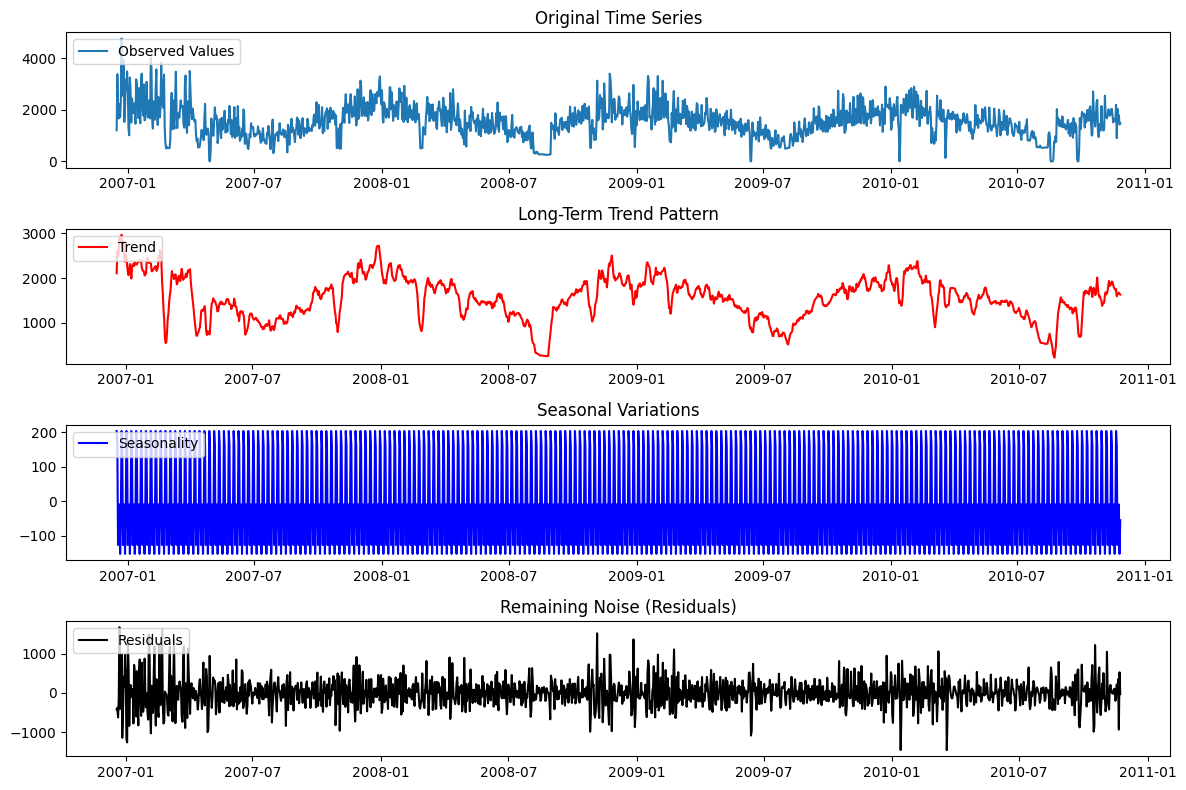

In [6]:
# Autocorrelation Analysis
plt.figure(figsize=(14, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(daily_df['Global_active_power'],
         lags=40,
         ax=plt.gca(),
         title='Autocorrelation (ACF) of Daily Power Consumption',
         color='darkblue')
plt.xlabel('Lag (Days)')
plt.ylabel('Correlation Coefficient')
plt.grid(alpha=0.3)

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(daily_df['Global_active_power'],
          lags=40,
          ax=plt.gca(),
          title='Partial Autocorrelation (PACF) of Daily Power Consumption',
          color='darkgreen')
plt.xlabel('Lag (Days)')
plt.ylabel('Partial Correlation')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Stationarity Analysis
print("\n" + "="*60)
print("Time Series Stationarity Evaluation".center(60))
print("="*60)
adf_test(daily_df['Global_active_power'], "Daily Power Consumption Data")

# Time Series Decomposition
print("\n" + "="*60)
print("Time Series Components Analysis".center(60))
print("="*60)
decompose_time_series(daily_df['Global_active_power'],
                     seasonal_period=7,  # Weekly seasonality
                     model='additive')


ARIMA Model Performance Evaluation:
Metric                                   Value
---------------------------------------------
Mean Absolute Error (MAE)             382.1085
Root Mean Squared Error (RMSE)        499.0858
Mean Absolute Percentage Error (MAPE)           43.86%


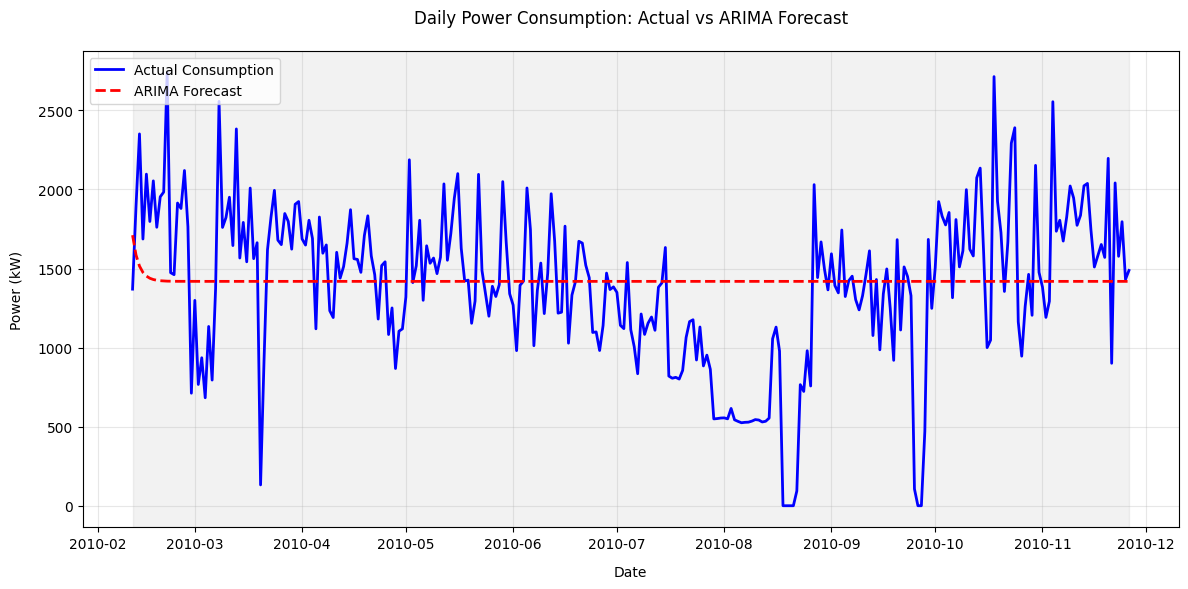

In [7]:
# ==============================================
# Time Series Forecasting with ARIMA
# ==============================================

# Prepare time series data
power_series = daily_df['Global_active_power']
train_data, test_data = train_test_split(
    power_series,
    test_size=0.2,
    shuffle=False  # Critical for time series
)

# Apply log transformation (adding 1 to handle zeros)
train_log = np.log1p(train_data)
test_log = np.log1p(test_data)

# ARIMA Model Configuration
best_order = (1, 0, 0)  # AR(1) model based on prior analysis

# Model Training
arima_model = ARIMA(
    train_log,
    order=best_order
)
fitted_model = arima_model.fit()

# Generate Forecasts
log_forecast = fitted_model.forecast(steps=len(test_log))
forecast_values = np.expm1(log_forecast)  # Reverse log transform

# ==============================================
# Model Evaluation Metrics
# ==============================================

mae = mean_absolute_error(test_data, forecast_values)
rmse = np.sqrt(mean_squared_error(test_data, forecast_values))

# Calculate MAPE only for non-zero actual values
non_zero_mask = test_data != 0
mape = np.mean(
    np.abs((test_data[non_zero_mask] - forecast_values[non_zero_mask]) /
    test_data[non_zero_mask])
) * 100

# Print evaluation results
print("\nARIMA Model Performance Evaluation:")
print(f"{'Metric':<30} {'Value':>15}")
print("-"*45)
print(f"{'Mean Absolute Error (MAE)':<30} {mae:>15.4f}")
print(f"{'Root Mean Squared Error (RMSE)':<30} {rmse:>15.4f}")
print(f"{'Mean Absolute Percentage Error (MAPE)':<30} {mape:>15.2f}%")

# ==============================================
# Visualization of Results
# ==============================================

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data,
         label='Actual Consumption',
         color='blue',
         linewidth=2)
plt.plot(test_data.index, forecast_values,
         label='ARIMA Forecast',
         color='red',
         linestyle='--',
         linewidth=2)

plt.title('Daily Power Consumption: Actual vs ARIMA Forecast', pad=20)
plt.xlabel('Date', labelpad=10)
plt.ylabel('Power (kW)', labelpad=10)
plt.legend(loc='upper left', frameon=True)
plt.grid(True, alpha=0.3)

# Add shaded region for forecast period
plt.axvspan(test_data.index[0], test_data.index[-1],
            color='grey', alpha=0.1, label='Forecast Period')

plt.tight_layout()
plt.show()